In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("Bank_Marketing_Original_Data.csv")

# Exploratory Data Analysis (EDA)

In [3]:
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (45211, 17)


,Age,Job,Marital,Education,Default,Balance,Housing,Loan,contact,Day,Month,Duration,Campaign,Pdays,Previous,poutcome,TARGET
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Age          0
Job          0
Marital      0
Education    0
Default      0
Balance      0
Housing      0
Loan         0
contact      0
Day          0
Month        0
Duration     0
Campaign     0
Pdays        0
Previous     0
poutcome     0
TARGET       0
dtype: int64


In [5]:
# Class distribution
target_dist = df['TARGET'].value_counts(normalize=True)
print("\nTarget variable distribution:")
print(target_dist)


Target variable distribution:
TARGET
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


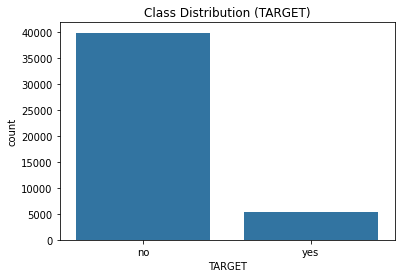

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='TARGET', data=df)
plt.title('Class Distribution (TARGET)')
plt.show()

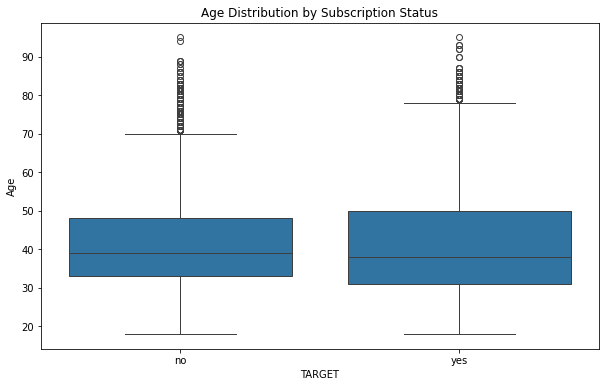

In [7]:
# Age vs Subscription
plt.figure(figsize=(10,6))
sns.boxplot(x='TARGET', y='Age', data=df)
plt.title('Age Distribution by Subscription Status')
plt.show()

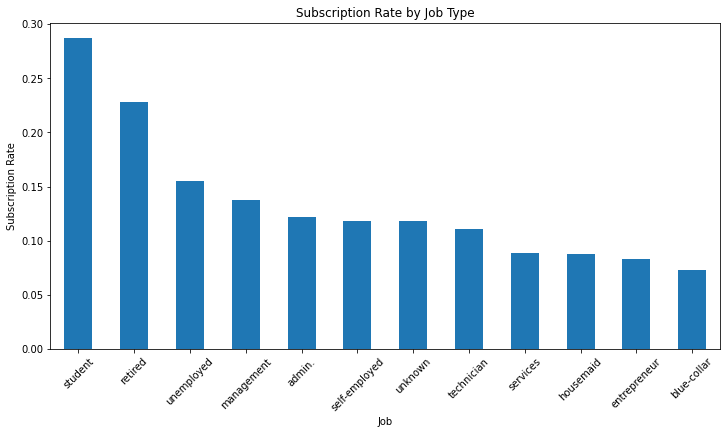

In [8]:
# Job vs Subscription rate
plt.figure(figsize=(12,6))
job_sub = df.groupby(['Job', 'TARGET']).size().unstack()
job_sub['subscription_rate'] = job_sub['yes'] / (job_sub['yes'] + job_sub['no'])
job_sub = job_sub.sort_values('subscription_rate', ascending=False)
job_sub['subscription_rate'].plot(kind='bar')
plt.title('Subscription Rate by Job Type')
plt.ylabel('Subscription Rate')
plt.xticks(rotation=45)
plt.show()

# Preprocessing

In [9]:
X = df.drop('TARGET', axis=1)
y = df['TARGET'].map({'no':0, 'yes':1})

In [10]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [11]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Logistic Regression

In [13]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

In [14]:
print("Logistic Regression Performance:")
print(f"Accuracy : {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba_lr):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_lr):.4f}")

Logistic Regression Performance:
Accuracy : 0.9012
AUC-ROC  : 0.9056
F1 Score : 0.4518


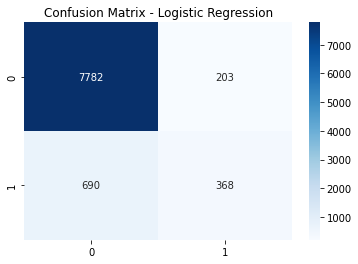

In [15]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Random Forest + SMOTE

In [16]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'Balance', 'Day', 'Duration', 'Campaign', 'Pdays', 'Previous'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent'...
                                                                         Index(['Job', 'Marital', 'Education', 'Default', 'Housing', 'Loan', 'contact',
       'Month', 'poutcome'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='roc_auc')

In [17]:
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

In [18]:
print("\nRandom Forest with SMOTE Performance:")
print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba_rf):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_rf):.4f}")


Random Forest with SMOTE Performance:
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Accuracy : 0.9034
AUC-ROC  : 0.9284
F1 Score : 0.5901


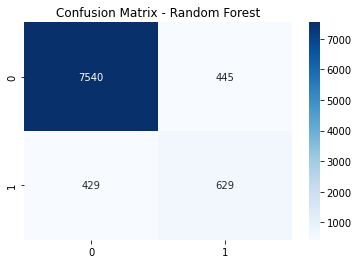

In [19]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

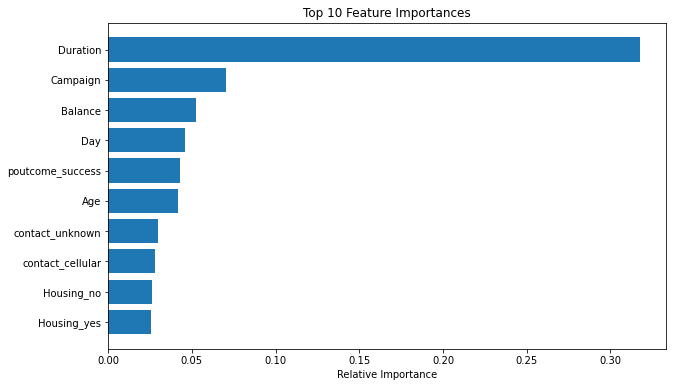

In [20]:
if hasattr(best_rf.named_steps['classifier'], 'feature_importances_'):
    ohe = best_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    all_feature_names = np.concatenate([num_cols, cat_feature_names])

    importances = best_rf.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[-10:]

    plt.figure(figsize=(10,6))
    plt.barh(range(10), importances[indices], align='center')
    plt.yticks(range(10), all_feature_names[indices])
    plt.xlabel("Relative Importance")
    plt.title("Top 10 Feature Importances")
    plt.show()

# Model Comparison

In [21]:
print("\nModel Comparison:")
print(f"{'Metric':<15}{'Logistic Regression':<22}{'Random Forest':<15}")
print(f"{'Accuracy':<15}{accuracy_score(y_test, y_pred_lr):<22.4f}{accuracy_score(y_test, y_pred_rf):<15.4f}")
print(f"{'AUC-ROC':<15}{roc_auc_score(y_test, y_proba_lr):<22.4f}{roc_auc_score(y_test, y_proba_rf):<15.4f}")
print(f"{'F1 Score':<15}{f1_score(y_test, y_pred_lr):<22.4f}{f1_score(y_test, y_pred_rf):<15.4f}")


Model Comparison:
Metric         Logistic Regression   Random Forest  
Accuracy       0.9012                0.9034         
AUC-ROC        0.9056                0.9284         
F1 Score       0.4518                0.5901         


In [22]:
import joblib

joblib.dump(best_rf, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']